<a href="https://colab.research.google.com/github/AndreyBONCH/ds_yandex_practicum/blob/main/%D0%9E%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D1%80%D1%8B%D0%BD%D0%BE%D1%87%D0%BD%D0%BE%D0%B9_%D1%81%D1%82%D0%BE%D0%B8%D0%BC%D0%BE%D1%81%D1%82%D0%B8_%D0%BE%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D0%BE%D0%B2_%D0%BD%D0%B5%D0%B4%D0%B2%D0%B8%D0%B6%D0%B8%D0%BC%D0%BE%D1%81%D1%82%D0%B8_(%D0%BF%D0%BE%D1%80%D1%84%D0%BE%D0%BB%D0%B8%D0%BE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет.<br>
<u>Цель работы:</u> научиться определять рыночную стоимость объектов недвижимости и выявить параметры, которые на нее влияют. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. <br>

<u>Примечание</u> <br>
По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

## Импорт библиотек и настройка отображения

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import sys, warnings
warnings.simplefilter("ignore")

## Функции

In [39]:
def uppercase_split(loc_full_name, return_name = 1):
    '''
    Функция для "разрезания" строк по заглавной букве в столбце (т.е. отделяет тип населенного пункта от его названия.
    Возвращает кортеж, где 0й элемент - тип населенного пункта, 1й - название.
    '''
    loc_name, loc_type = [], []
    loc_full_name = str(loc_full_name).split()
    for idx, word in enumerate(loc_full_name):
        if word.istitle():
            loc_type = loc_full_name[:idx]
            loc_name = loc_full_name[idx:]
            break
    if return_name:
        return ' '.join(loc_name)
    return ' '.join(loc_type)

In [40]:
def type_of_floor(fl, tot_fl):
    '''
    Функция для категоризации этажей
    fl - номер этажа
    tot_fl - всего этажей
    '''
    if fl == 1:
        return 'первый'
    elif fl == tot_fl:
        return 'последний'
    return 'другой'

## Загрузка данных

In [41]:
try:
    data = pd.read_csv('real_estate_data.csv', sep = '\t')
except:
    try:
        data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
    except:
        data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep = '\t')
        print('')

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

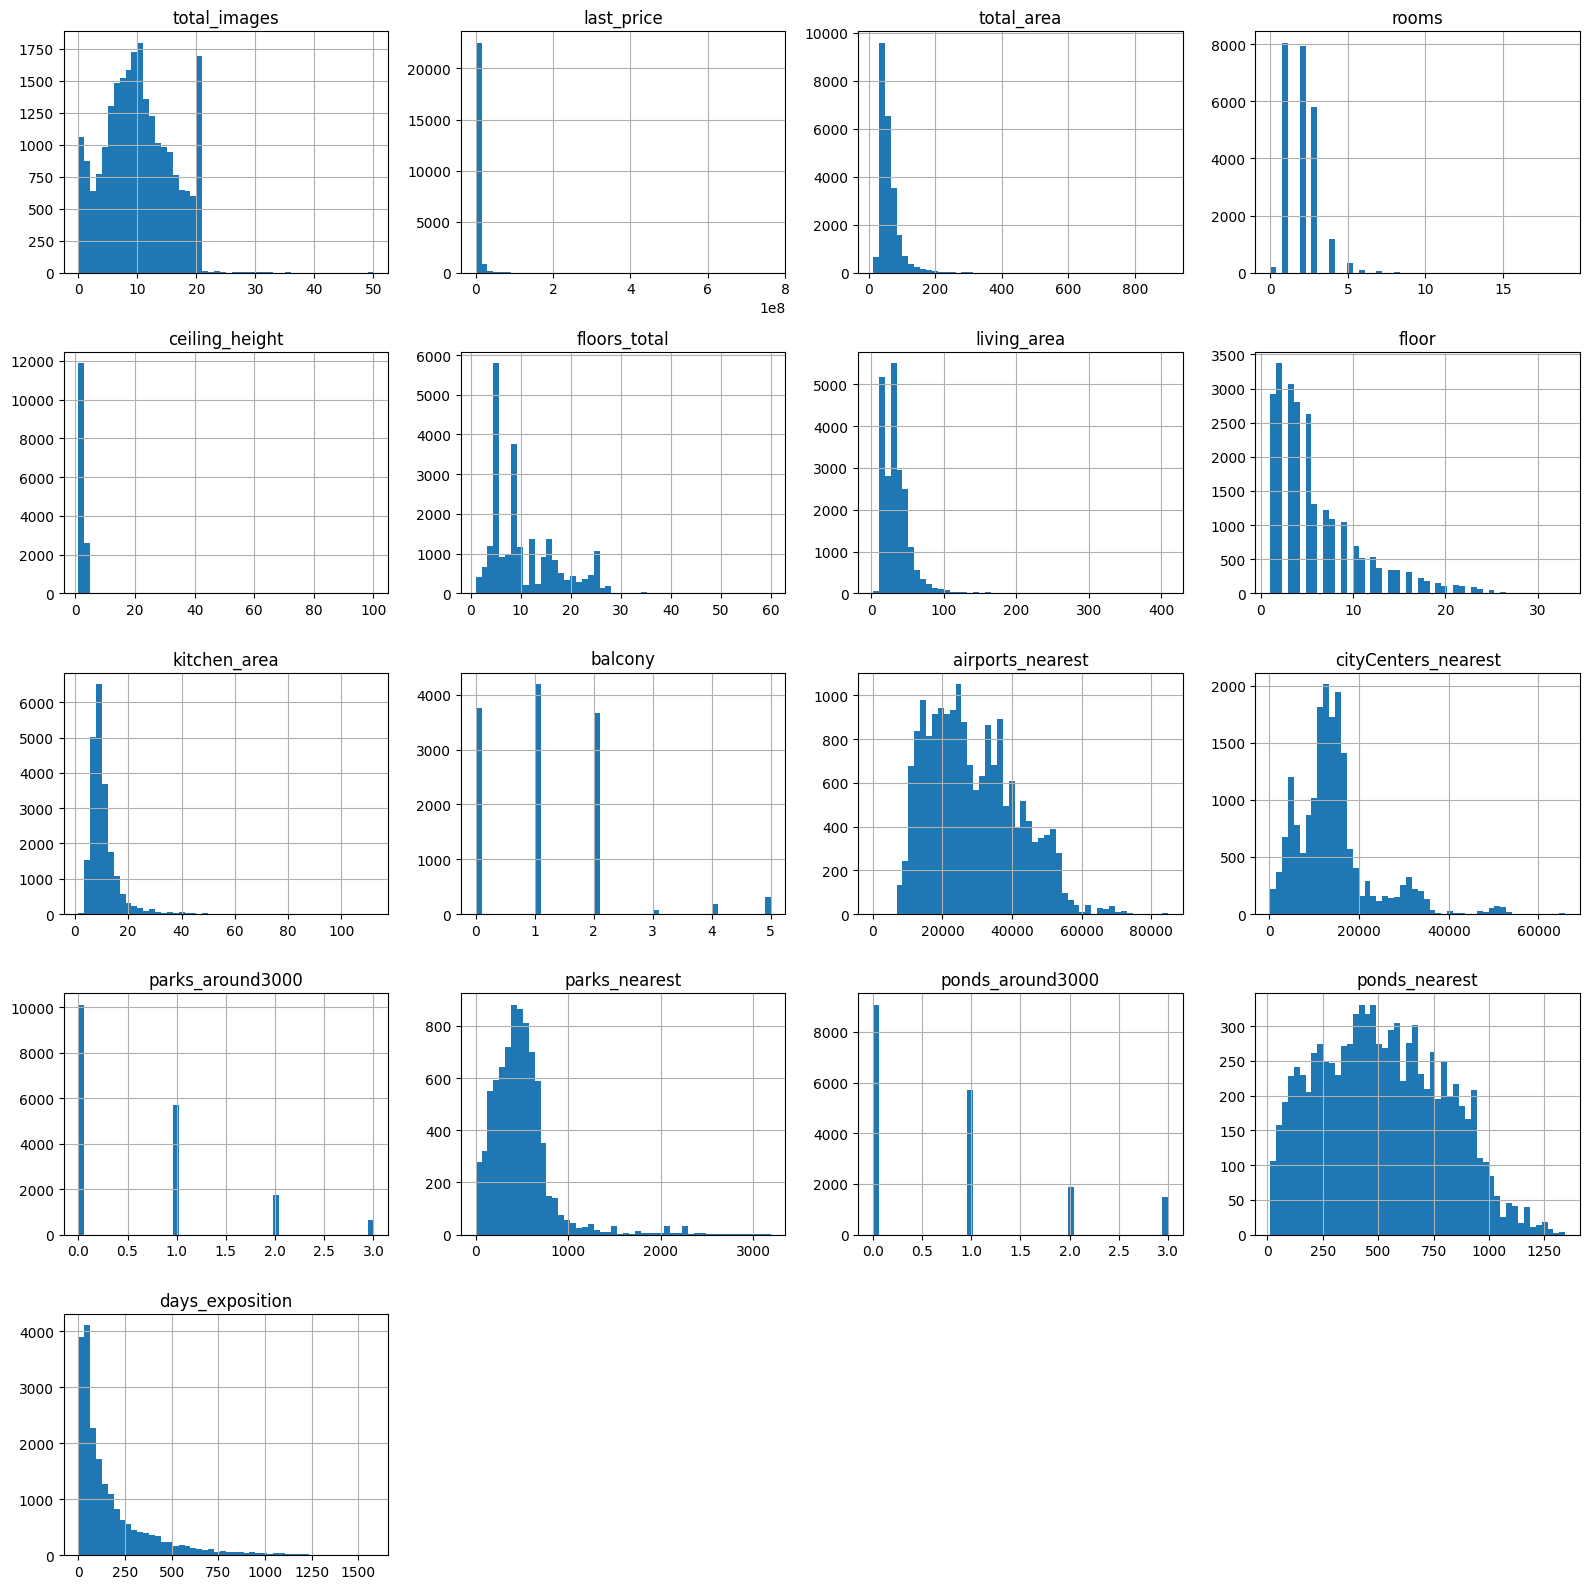

In [43]:
data.hist(bins = 50,
          figsize = (16, 16),
         )
plt.tight_layout()

### Анализ пропусков

In [44]:
display((data.isna().sum()/data.shape[0]*100).round(2).sort_values(ascending = False))

is_apartment            88.29
parks_nearest           65.91
ponds_nearest           61.56
balcony                 48.61
ceiling_height          38.80
airports_nearest        23.38
cityCenters_nearest     23.29
ponds_around3000        23.28
parks_around3000        23.28
days_exposition         13.42
kitchen_area             9.61
living_area              8.03
floors_total             0.36
locality_name            0.21
total_images             0.00
last_price               0.00
studio                   0.00
floor                    0.00
rooms                    0.00
first_day_exposition     0.00
total_area               0.00
open_plan                0.00
dtype: float64

#### Анализ результата
<div class="alert alert-info">
Как видим, много пропущенных значений в столбцах. 

Всего объектов недвижимости - 23699. В таблице процент пропусков от общего количества записей...

Параметр недвижимости                | Не указано, %
------                               | :-------- 
Аппартаменты? (да/нет)               |  **88.29**
Расстояние до ближайшего парка (м)   |  **65.91**
Расстояние до ближайшего водоема (м) |  **61.56**
Количество балконов (шт.)            |  **48.61**
Высота потолков (м)                  |  **38.80**
Расстояние до аэропорта (м)          |  **23.38**
Расстояние до центра (м)             |  **23.29**
Число водоёмов в радиусе 3 км (шт)   |  **23.28**
Число парков в радиусе 3 км (шт)     |  **23.28**
Длительность рамещения объявления (дней) |  **13.42**
Площадь кухни (м.кв.)                |   **9.61**
Жилая площадь (м.кв.)                |   **8.03**
Количество этажей в здании           |   **0.36**
Название населенного пункта          |   **0.21**
</div>

In [45]:
# Статистика по высоте потолков из данной выборки
data.ceiling_height.describe() 

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

In [46]:
# Изучение пропусков в столбце "Наличие аэропорта"
data.query('airports_nearest.isna()')['locality_name'].value_counts().head(20)

посёлок Мурино             522
Всеволожск                 398
Гатчина                    307
деревня Кудрово            299
Выборг                     237
Кудрово                    173
деревня Новое Девяткино    144
Сертолово                  142
Кириши                     125
Сланцы                     112
Волхов                     111
Тосно                      104
Кингисепп                  104
Никольское                  93
Коммунар                    89
Сосновый Бор                87
Санкт-Петербург             85
Кировск                     84
Отрадное                    80
посёлок Бугры               69
Name: locality_name, dtype: int64

### Изучение типов данных

In [47]:
data.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment             object
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object

#### Анализ результата
<div class="alert alert-info">

<i>Ряд важных параметров имеют некорректные типы данных, а именно:<br>
    - 'floors_total', 'rooms', 'balcony', 'parks_around3000', 'ponds_around3000', 'days_exposition' имеют тип float,
хотя описывают целочисленные параметры;<br>
    - 'first_day_exposition' имеет тип object, хотя хранит данные о дате и времени.
</i>
</div>

### Изучение явных дубликатов

In [48]:
data.duplicated().sum()

0

#### Анализ результата
<div class="alert alert-info">
<i>Явных дубликатов - <b>нет</b>.</i>
</div>

### Изучение выбросов и аномалий

In [49]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


#### Анализ результата
<div class="alert alert-info">
<i><b>О цене:</b> в большинстве случаев цены варьируются от 3,4 до 6,8 млн.руб., но есть выбросы до 763 млн.руб.</i><br>
<i><b>Об площади и количестве комнат:</b> <br>    
а) общая площать аномально достигает 900 кв.м., жилая площадь превышает 400 кв.м., а площадь кухни 112 кв.м.;<br>    
б) также кажутся странными квартиры с жилой площадью 2 кв.м., или с кухней 1.3 кв.м.,  или с общей площадью 12 кв.м.;<br>
в) также встречаются 19-ти комнатные квартиры.</i><br>
<i><b>О высоте потолков:</b> явные ошибки и опечатки в данных, иначе откуда высота потолка в квартире 1 м или 100 м??</i><br>
<i><b>О длительности продаж:</b> чаще всего квартиры продаются за 95 дней, однако есть случаи, когда длительность размещения объявления достигает 1580 дней 0_о.</i>
</div>

## Предобработка данных

### План действий, основанный на наблюдениях
1. Почти **90 %** объектов имеют пропуск в графе `"Аппартаменты"`, предположим, что ***пропуск*** - это ***False***.
2. На втором месте по пропускам `расстояния до ближайших парков и водоемов` - **61,5%** и **65,9%**, соответственно. Возможно люди не обращают на это внимания. ***Заполняю значением 3000***, так как в таком случае до ближайшего парка и водоема расстояние будет очень велико и не должно скажется на исследовании.
3. `Наличие балкона` не указано почти в **49%** случаев. Предположу, что ***балкона нет***. Для Санкт-Петербурга, например, это не редкость, старый фонд, все таки.
4. `Высоту потолков` можно ***предугадать*** по высотности здания, либо просто ***указав медианное значение***, потому что, по-моему, это не главный показатель. Учитывая то, что *квартильный разброс высоты потолка от 2.52 до 2.8 м*. Хотя в данных присутствуют и большие выбросы, вплоть до 100 м. Об этом позднее.
5. Далее примерно по 23 % пропусков в 4 столбцах: `Расстояние до аэропорта`, `Расстояние до центра`, `Число водоёмов в радиусе 3 км` и в `Число парков в радиусе 3 км`. Рассмотрим по отдельности:

    а) `расстояние до аэропорта` не указано в подавляющем числе случаев тогда, когда в населенном пункте аэропорта либо нет, либо он находится очень далеко. ***Заменю пропущенные значения в таком случае на 100000 м***, что будет означать - очень далеко. Кстати, в СПб не указано расстояние до аэропорта только в 85 случаях (0,54%);
    
    б) `расстояние до центра` один из важнейших параметров, определяющий стоимость квадратного метра жилья. ***Заменю на медианное значение по населенному пункту***, но только после того, как названия населенных пунктов будут приведены в порядок;
    
    в) не указано `число парков и водоёмов в радиусе 3 км`, не беда, заменим на ***0***, видимо, их нет, или они не достаточно хороши, чтобы их указывать.
    
    
6. По `длительность рамещения объявления`, пропущенной почти в ***13,4%*** случаев можно предположить, что квартиры все еще в продаже. Этих пропусков довольно много, придется ***заменить их на 0***. Так будет понятно, что если 0, то все еще в продаже.
7. Пропущенные значения со значением *`площадей кухни`* и *`жилой площади`* стоит заменить ***медианным значением*** с учетом количества комнат в квартире.
8. Строки со значением `количества этажей в здании` и `названием населенного пункта` пропущены в менее чем 0,5 % случаев. Их можно просто удалить, это никак не повлияет на мой анализ.

In [50]:
# Заполняем значения в столбцах на значения в соответствии с планом
data.is_apartment.fillna(False, inplace = True) # По п.1
data[['parks_nearest','ponds_nearest']] = data[['parks_nearest','ponds_nearest']].fillna(3000) # По п.2
data.balcony.fillna(0, inplace = True) # По п.3
data.ceiling_height.fillna(data.ceiling_height.median(), inplace = True) # По п.4
data.airports_nearest.fillna(100000, inplace = True) # По п.5 перечисление а)
# По п.5 перечисление б) - будет сделано после корректировки дубликатов в названиях населенных пунктов.
data[['parks_around3000','ponds_around3000']] = data[['parks_around3000','ponds_around3000']].fillna(0) # По п.5 перечисление в)
data.days_exposition.fillna(0, inplace = True) # По п.6

for t in data['rooms'].unique():  # По п.7
    data.loc[(data['rooms'] == t) & (data['kitchen_area'].isna()), 'kitchen_area'] = \
    data.loc[(data['rooms'] == t), 'kitchen_area'].median()
   
for t in data['rooms'].unique():  # По п.7
    data.loc[(data['rooms'] == t) & (data['living_area'].isna()), 'living_area'] = \
    data.loc[(data['rooms'] == t), 'living_area'].median()
# По п.8 будет сделано после корректировки дубликатов в названиях населенных пунктов.
 
(data.isna().sum()/data.shape[0]*100).round(2).sort_values(ascending = False)

cityCenters_nearest     23.29
kitchen_area             0.83
floors_total             0.36
locality_name            0.21
total_images             0.00
ponds_nearest            0.00
ponds_around3000         0.00
parks_nearest            0.00
parks_around3000         0.00
airports_nearest         0.00
balcony                  0.00
open_plan                0.00
last_price               0.00
studio                   0.00
is_apartment             0.00
floor                    0.00
living_area              0.00
ceiling_height           0.00
rooms                    0.00
first_day_exposition     0.00
total_area               0.00
days_exposition          0.00
dtype: float64

<div class="alert alert-info">
Итого, избавились от части пропусков. Пока достаточно.
</div>

### Изучение и устранение неявных дубликатов

<div class="alert alert-info">
Изменю порядок предобработки, чтобы доделать предыдущий пункт.
Для справки, неявные дубликаты, это, например, «поселок Рябово» и «поселок городского типа Рябово», «поселок Тельмана» и «посёлок Тельмана» — это обозначения одних и тех же населённых пунктов.
</div>

In [51]:
data['locality_name'] = data['locality_name'].str.replace('ё','е') # Уберем все точки над "е"

In [52]:
data['locality_only_name'] = data['locality_name'].apply(uppercase_split, return_name = 1)
data['locality_type'] = data['locality_name'].apply(uppercase_split, return_name = 0)
data = data.reindex(columns = ['total_images', 'last_price', 'living_area','total_area', 'kitchen_area', 'floor', 
       'first_day_exposition', 'rooms', 'ceiling_height', 'floors_total', 
       'is_apartment', 'studio', 'open_plan', 'balcony',
       'locality_type', 'locality_only_name', 'locality_name',
        'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'])
data = data.rename(columns = {'locality_only_name': 'locality_name', 'locality_name': 'locality_full_name'})

In [53]:
data = data.query('locality_name != ""') # Удалил пустые строки с названием города.
# Итого получилась таблица со столбцом, содержащим только уникальные значения названий населенных пунктов 
display(data.sample(20))
print(f'Всего таких населенных пунктов: {len(data.locality_name.unique())}')

,total_images,last_price,living_area,total_area,kitchen_area,floor,first_day_exposition,rooms,ceiling_height,floors_total,is_apartment,studio,open_plan,balcony,locality_type,locality_name,locality_full_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
12268,1,2685000.0,17.60,24.7,9.04,1,2019-01-11T00:00:00,1,2.65,5.0,False,False,False,0.0,,Санкт-Петербург,Санкт-Петербург,10986.0,9027.0,1.0,576.0,1.0,1020.0,39.0
7324,13,5000000.0,30.10,46.3,8.30,5,2017-09-12T00:00:00,2,2.55,9.0,False,False,False,0.0,,Зеленогорск,Зеленогорск,71869.0,52968.0,3.0,174.0,2.0,561.0,28.0
952,0,3800000.0,17.80,37.7,11.40,2,2017-09-10T00:00:00,1,2.65,24.0,False,False,False,1.0,поселок,Мурино,поселок Мурино,100000.0,NaN,0.0,3000.0,0.0,3000.0,3.0
20523,7,3250000.0,18.70,33.0,6.80,7,2017-09-05T00:00:00,1,2.60,9.0,False,False,False,0.0,,Санкт-Петербург,Санкт-Петербург,13943.0,16534.0,0.0,3000.0,0.0,3000.0,336.0
10289,9,1900000.0,46.90,61.5,5.90,5,2019-04-17T00:00:00,3,2.65,5.0,False,False,False,1.0,,Приозерск,Приозерск,100000.0,NaN,0.0,3000.0,0.0,3000.0,0.0
17687,1,6000000.0,30.00,54.4,8.60,5,2017-10-14T00:00:00,2,2.60,17.0,False,False,False,1.0,,Санкт-Петербург,Санкт-Петербург,7994.0,12688.0,1.0,624.0,0.0,3000.0,24.0
7887,8,2950000.0,30.30,53.2,8.50,2,2017-02-14T00:00:00,2,2.65,5.0,False,False,False,0.0,,Тосно,Тосно,100000.0,NaN,0.0,3000.0,0.0,3000.0,51.0
10005,9,17500000.0,41.00,72.0,12.00,5,2018-09-11T00:00:00,2,2.65,8.0,False,False,False,0.0,,Санкт-Петербург,Санкт-Петербург,39412.0,10186.0,1.0,1424.0,3.0,204.0,4.0
2054,5,2100000.0,25.00,45.0,6.00,2,2017-11-28T00:00:00,2,2.65,2.0,False,False,False,0.0,,Гатчина,Гатчина,100000.0,NaN,0.0,3000.0,0.0,3000.0,66.0
4759,3,7900000.0,44.00,70.0,11.70,1,2017-06-22T00:00:00,3,3.20,6.0,False,False,False,0.0,,Санкт-Петербург,Санкт-Петербург,25069.0,3644.0,1.0,542.0,0.0,3000.0,599.0


Всего таких населенных пунктов: 305


<div class="alert alert-info">
<b><i>Итак, настало время дообработать пропуски в данных ;)</i></b>

*Напомню, расстояние до центра планировалось заменить на медианное значение по населенному пункту, а потом удалить все оставшиеся пустые значения, так как их почти не останется в таблице. Приступим.* 
</div>

In [54]:
for t in data['locality_name'].unique():  # По п.5 перечисление б)
    data.loc[(data['locality_name'] == t) & (data['cityCenters_nearest'].isna()), 'cityCenters_nearest'] = \
    data.loc[(data['locality_name'] == t) & (~data['cityCenters_nearest'].isna()), 'cityCenters_nearest'].median()

distances_median = data.groupby('locality_name')['cityCenters_nearest'].median()
distances_median = distances_median.reset_index()
display(distances_median.sample(30))
100 - distances_median.cityCenters_nearest.isna().sum()/len(distances_median.cityCenters_nearest)*100

,locality_name,cityCenters_nearest
207,Разбегаево,NaN
57,Жилгородок,NaN
88,Колпино,32018.0
138,Меньково,NaN
141,Мистолово,NaN
109,Курковицы,NaN
146,Мурино,21888.0
128,Лукаши,NaN
161,Новый Свет,NaN
43,Гладкое,NaN


8.85245901639344

<div class="alert alert-info">
Как видим, часть пропусков удалось заменить медианным значением (менее 9 % от всех). Остальные заменю "заглушкой" - 0.
</div>

In [55]:
data['cityCenters_nearest'].fillna(0, inplace = True)

In [56]:
print('Пропуски позаполняли, вот и результат: ')
(data.isna().sum()/data.shape[0]*100).round(2).sort_values(ascending = False)

Пропуски позаполняли, вот и результат: 


kitchen_area            0.83
floors_total            0.36
total_images            0.00
balcony                 0.00
ponds_nearest           0.00
ponds_around3000        0.00
parks_nearest           0.00
parks_around3000        0.00
cityCenters_nearest     0.00
airports_nearest        0.00
locality_full_name      0.00
locality_name           0.00
locality_type           0.00
open_plan               0.00
last_price              0.00
studio                  0.00
is_apartment            0.00
ceiling_height          0.00
rooms                   0.00
first_day_exposition    0.00
floor                   0.00
total_area              0.00
living_area             0.00
days_exposition         0.00
dtype: float64

<div class="alert alert-info">
Теперь просто удалим строки с пропусками, их осталось очень мало, менее 1 %.
</div>    

In [57]:
data.dropna(inplace = True)
data.reset_index(drop = True)
data.isna().sum().sum()

0

### Исследование типов данных

In [58]:
display(data.dtypes)
data.select_dtypes('float64').columns

total_images              int64
last_price              float64
living_area             float64
total_area              float64
kitchen_area            float64
floor                     int64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
is_apartment               bool
studio                     bool
open_plan                  bool
balcony                 float64
locality_type            object
locality_name            object
locality_full_name       object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object

Index(['last_price', 'living_area', 'total_area', 'kitchen_area',
       'ceiling_height', 'floors_total', 'balcony', 'airports_nearest',
       'cityCenters_nearest', 'parks_around3000', 'parks_nearest',
       'ponds_around3000', 'ponds_nearest', 'days_exposition'],
      dtype='object')

<div class="alert alert-info">
Необходимо изменить на целочисленный тип значения столбцов:<br>
- <i><mark>floors_total</mark>, <mark>last_price</mark>, <mark>rooms</mark>, <mark>balcony</mark>, <mark>parks_around3000</mark>, <mark>ponds_around3000, <mark>days_exposition</mark></i>
</div> 


In [59]:
for col in ['floors_total', 'last_price', 'rooms', 'balcony', 'parks_around3000', 'ponds_around3000', 'days_exposition']:
    data[col] = data[col].astype(int)

data[['floors_total', 'last_price', 'rooms', 'balcony', 'parks_around3000', 'ponds_around3000', 'days_exposition']].dtypes

floors_total        int64
last_price          int64
rooms               int64
balcony             int64
parks_around3000    int64
ponds_around3000    int64
days_exposition     int64
dtype: object

<div class="alert alert-info">
Теперь необходимо изменить тип данных в столбцах с датами, т.е. в <mark>first_day_exposition</mark>
</div> 

In [60]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data.sample(20)

,total_images,last_price,living_area,total_area,kitchen_area,floor,first_day_exposition,rooms,ceiling_height,floors_total,is_apartment,studio,open_plan,balcony,locality_type,locality_name,locality_full_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
13925,15,9390000,35.0,68.0,11.00,10,2018-10-22,2,3.00,24,False,False,False,1,,Санкт-Петербург,Санкт-Петербург,39653.0,8913.0,0,3000.0,0,3000.0,150
22594,2,3960396,36.0,54.4,10.94,1,2015-02-13,2,2.80,18,False,False,False,0,деревня,Новое Девяткино,деревня Новое Девяткино,100000.0,0.0,0,3000.0,0,3000.0,880
1767,1,4400000,18.0,39.0,12.00,12,2016-03-18,1,2.65,15,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,17632.0,15973.0,1,38.0,0,3000.0,102
13833,10,3350000,30.3,44.7,7.20,2,2019-03-20,2,2.65,5,False,False,False,1,,Сосновый Бор,Сосновый Бор,100000.0,0.0,0,3000.0,0,3000.0,10
12757,7,3240000,27.3,57.9,12.50,3,2019-03-02,2,2.65,4,False,False,False,0,деревня,Аро,деревня Аро,100000.0,0.0,0,3000.0,0,3000.0,0
8171,20,5205000,13.0,33.0,8.00,1,2018-10-01,1,3.00,6,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,10819.0,9072.0,0,3000.0,0,3000.0,9
23227,10,4600000,23.0,38.0,7.00,4,2019-04-26,2,2.65,9,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,44421.0,11058.0,1,283.0,2,448.0,0
3844,10,1550000,29.6,53.3,8.30,1,2018-08-24,2,2.50,5,False,False,False,1,поселок городского типа,Кузнечное,поселок городского типа Кузнечное,100000.0,0.0,0,3000.0,0,3000.0,0
15962,11,1000000,32.0,58.0,7.00,1,2018-08-09,3,2.65,5,False,False,False,0,,Сланцы,Сланцы,100000.0,0.0,0,3000.0,0,3000.0,0
2060,12,1950000,32.0,47.0,5.00,2,2018-08-07,2,2.50,5,False,False,False,0,поселок,Молодцово,поселок Молодцово,100000.0,0.0,0,3000.0,0,3000.0,65


### Исследование и устранение аномалий
<div class="alert alert-info">
Аномалиями могут быть, например, значения в столбце <mark>ceiling_height</mark> может быть указана высота потолков 25 м и 32 м. Логично предположить, что на самом деле это вещественные значения: 2.5 м и 3.2 м.
</div>

#### Высота потолков

In [61]:
data.loc[data['ceiling_height'] >= 16, 'ceiling_height'] = data.loc[data['ceiling_height'] >= 16, 'ceiling_height']/10

In [62]:
print(data.ceiling_height.describe()['50%'] - data.ceiling_height.describe()['std']) # Медиана минус стандартное отклонение
print(data.ceiling_height.describe()['50%'] + data.ceiling_height.describe()['std']) # Медиана плюс стандартное отклонение
data.ceiling_height.describe() # ну и посмотрим, насколько эти значения похожи на квартили.

2.3964334428045113
2.9035665571954885


count    23371.000000
mean         2.698597
std          0.253567
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         14.000000
Name: ceiling_height, dtype: float64

In [63]:
# Теперь посчитаю, сколько значений не входят в диапазон от 2,4 до 2,9 м
low_ceilings = data.query('2.4 > ceiling_height')['ceiling_height'].count()/data['ceiling_height'].count()
hight_ceilings = data.query('ceiling_height > 2.9')['ceiling_height'].count()/data['ceiling_height'].count()
print(f'Ниже 2.4 метра потолки у {low_ceilings:.2%} квартир.')
print(f'Выше 2.9 метров потолки у {hight_ceilings:.2%} квартир.')

Ниже 2.4 метра потолки у 0.10% квартир.
Выше 2.9 метров потолки у 11.47% квартир.


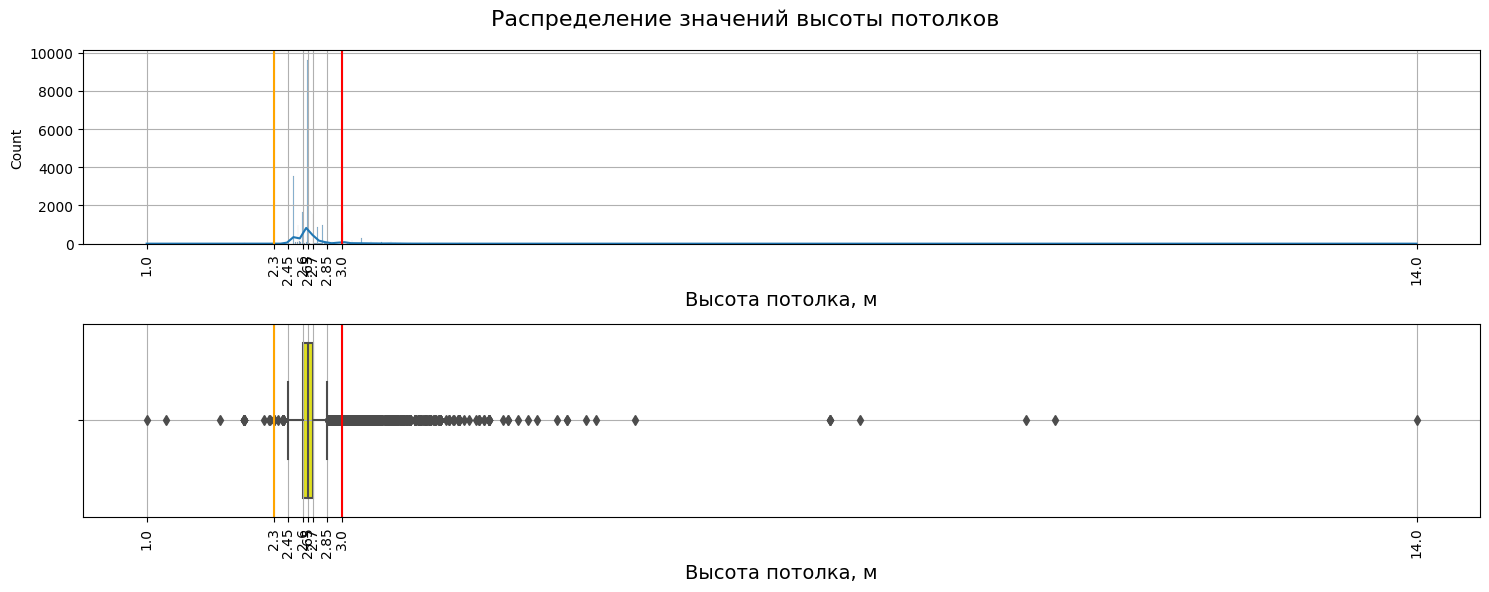

In [64]:
fig, axes = plt.subplots(2, figsize = (15, 6))
fig.suptitle('Распределение значений высоты потолков', fontsize=16)

Q1 =  data.ceiling_height.quantile(0.25)
Q3 = data.ceiling_height.quantile(0.75)
IQR = Q3 - Q1
lower_range = Q1-1.5*IQR
upper_range = Q3+1.5*IQR
lowest_range = Q1-3*IQR
uppest_range = Q3+3*IQR
ticks_list = np.array(sorted(data.loc[data['ceiling_height'] != 0, 'ceiling_height'].describe().to_list()[3:]\
                    +[lower_range, upper_range, lowest_range, uppest_range])).round(3)

sns.histplot(data = data, 
             x = 'ceiling_height',
             ax = axes[0],
             kde = True,
            )

sns.boxplot(data = data, 
             x = 'ceiling_height',
             ax = axes[1],
            color = 'Yellow',
           )

for i in [0, 1]:
    axes[i].axvline(x = lowest_range, 
                    color = 'orange',
                   )
    axes[i].axvline(x = uppest_range, 
                    color = 'r',
                   )
    axes[i].grid(True)
    axes[i].set_xlabel('Высота потолка, м', fontsize=14)
    axes[i].set_xticks(ticks_list)
    axes[i].set_xticklabels(axes[0].get_xticks(),rotation = 90)  

fig.tight_layout()

In [65]:
print('Из всех значений квартир с высотой потолка ниже 2.4 и выше 4.5 метров всего: ', data.query('4.5 <= ceiling_height | ceiling_height <= 2.4')['ceiling_height'].count())
print('И вот как они портят наш график. Удалим их.')

Из всех значений квартир с высотой потолка ниже 2.4 и выше 4.5 метров всего:  73
И вот как они портят наш график. Удалим их.


In [66]:
data = data.query('2.4 < ceiling_height <= 4.5') # Отрезаем лишнее

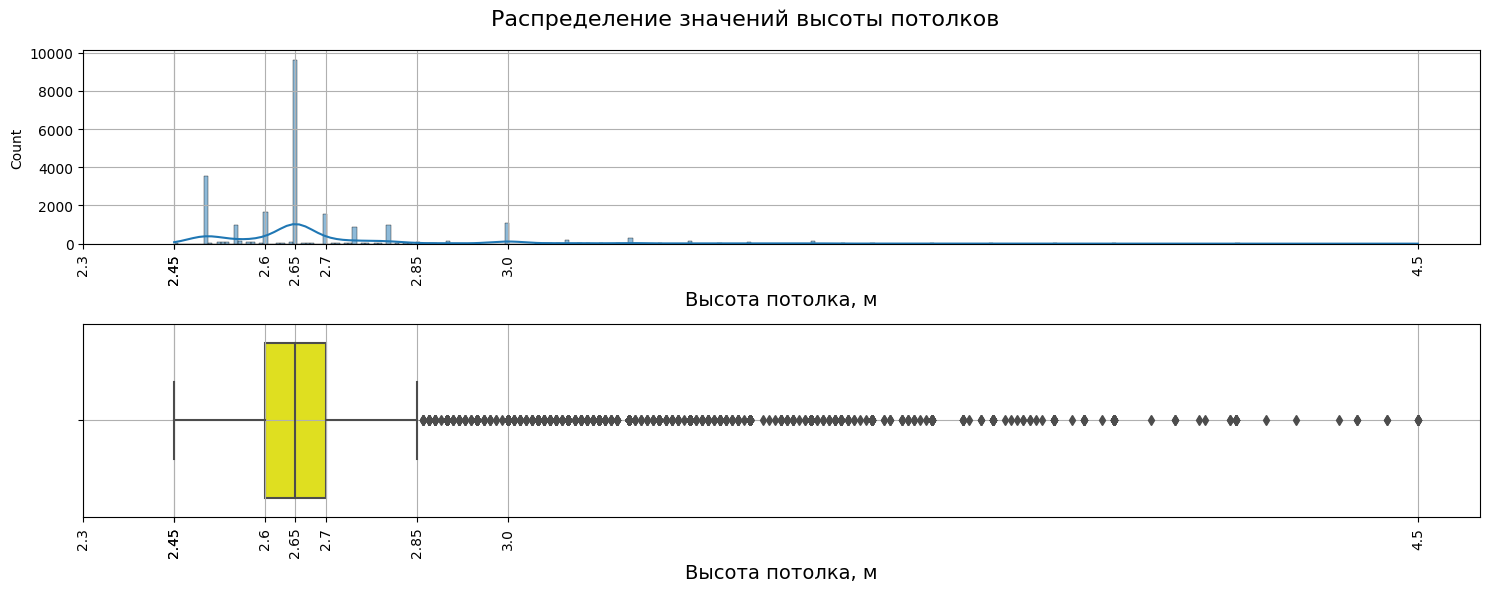

In [67]:
fig, axes = plt.subplots(2, figsize = (15, 6))
fig.suptitle('Распределение значений высоты потолков', fontsize=16)

Q1 =  data.ceiling_height.quantile(0.25)
Q3 = data.ceiling_height.quantile(0.75)
IQR = Q3 - Q1
lower_range = Q1-1.5*IQR
upper_range = Q3+1.5*IQR
lowest_range = Q1-3*IQR
uppest_range = Q3+3*IQR
ticks_list = np.array(sorted(data.loc[data['ceiling_height'] != 0, 'ceiling_height'].describe().to_list()[3:]\
                    +[lower_range, upper_range, lowest_range, uppest_range])).round(3)

sns.histplot(data = data, 
             x = 'ceiling_height',
             ax = axes[0],
             kde = True,
            )

sns.boxplot(data = data, 
             x = 'ceiling_height',
             ax = axes[1],
            color = 'Yellow',
           )

for i in [0, 1]:
#     axes[i].axvline(x = lowest_range, 
#                     color = 'orange',
#                    )
#     axes[i].axvline(x = uppest_range, 
#                     color = 'r',
#                    )
    axes[i].grid(True)
    axes[i].set_xlabel('Высота потолка, м', fontsize=14)
    axes[i].set_xticks(ticks_list)
    axes[i].set_xticklabels(axes[0].get_xticks(),rotation = 90)  

fig.tight_layout()

#### Общая площадь

In [68]:
data.total_area.describe()

count    23305.000000
mean        60.531174
std         35.339259
min         12.000000
25%         40.200000
50%         52.000000
75%         70.000000
max        900.000000
Name: total_area, dtype: float64

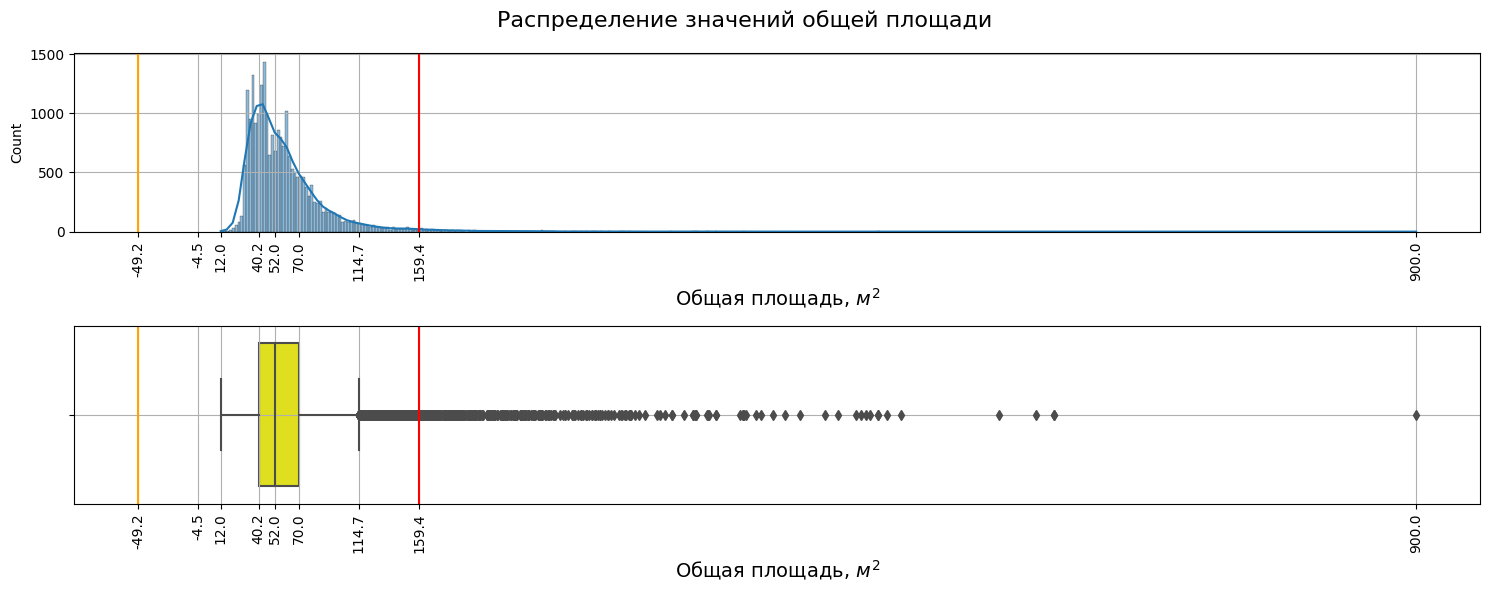

In [69]:
fig, axes = plt.subplots(2, figsize = (15, 6))
fig.suptitle('Распределение значений общей площади', fontsize=16)

Q1 =  data.total_area.quantile(0.25)
Q3 = data.total_area.quantile(0.75)
IQR = Q3 - Q1
lower_range = Q1-1.5*IQR
upper_range = Q3+1.5*IQR
lowest_range = Q1-3*IQR
uppest_range = Q3+3*IQR
ticks_list = np.array(sorted(data.loc[data['total_area'] != 0, 'total_area'].describe().to_list()[3:]\
                    +[lower_range, upper_range, lowest_range, uppest_range])).round(3)

sns.histplot(data = data, 
             x = 'total_area',
             ax = axes[0],
             kde = True,
            )

sns.boxplot(data = data, 
             x = 'total_area',
             ax = axes[1],
            color = 'Yellow',
           )

for i in [0, 1]:
    axes[i].axvline(x = lowest_range, 
                    color = 'orange',
                   )
    axes[i].axvline(x = uppest_range, 
                    color = 'r',
                   )
    axes[i].grid(True)
    axes[i].set_xlabel('Общая площадь, $м^2$', fontsize=14)
    axes[i].set_xticks(ticks_list)
    axes[i].set_xticklabels(axes[0].get_xticks(),rotation = 90)  

fig.tight_layout()

In [70]:
round(data.query('total_area > 200')['total_area'].count()/data['total_area'].count()*100, 2)

0.94

##### Анализ результата
<div class="alert alert-info">
Меньше одного процента квартир имеют общую площадь больше 200 м. Таким образом избавляемся от таких объектов.
</div>    

In [71]:
data = data.query('total_area < 200')

#### Жилая площадь

In [72]:
data.query('(living_area*10 + kitchen_area <= total_area)').sort_values(['total_area','living_area','kitchen_area'])

,total_images,last_price,living_area,total_area,kitchen_area,floor,first_day_exposition,rooms,ceiling_height,floors_total,is_apartment,studio,open_plan,balcony,locality_type,locality_name,locality_full_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3242,7,4440000,3.0,41.0,11.0,17,2017-07-02,1,2.65,17,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,19272.0,13073.0,0,3000.0,0,3000.0,216
13915,20,6350000,2.0,52.0,9.0,2,2018-02-06,2,3.00,6,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,32453.0,6521.0,0,3000.0,1,1012.0,91
21943,15,6100000,5.4,77.6,9.8,1,2019-02-28,4,2.50,9,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,29338.0,11270.0,1,584.0,0,3000.0,33
23574,14,64990000,3.0,139.0,16.0,8,2015-11-24,3,3.00,8,False,False,False,1,,Санкт-Петербург,Санкт-Петербург,33255.0,5975.0,1,630.0,3,100.0,280


<div class="alert alert-info"> 
Предполагаю, что значение жилой площади неправильно указано. Будет больше похоже на реальность, если умножить на 10.
</div>

In [73]:
data.loc[data['living_area']*10 + data['kitchen_area'] <= data['total_area'], 'living_area'] = data.loc[data['living_area']*10 + data['kitchen_area'] <= data['total_area']]['living_area']*10

In [74]:
display(data.query('((living_area + kitchen_area) - total_area)/ total_area >= 0.05'))
data.query('((living_area + kitchen_area) - total_area)/ total_area >= 0.05').sort_values(['living_area','kitchen_area','total_area'])['total_area'].count()

,total_images,last_price,living_area,total_area,kitchen_area,floor,first_day_exposition,rooms,ceiling_height,floors_total,is_apartment,studio,open_plan,balcony,locality_type,locality_name,locality_full_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
184,7,2600000,26.10,30.20,6.20,5,2018-02-14,1,2.65,9,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,13952.0,15031.0,0,3000.0,1,824.0,12
322,6,2000000,17.60,25.00,9.04,5,2017-02-07,1,2.65,5,False,False,False,0,,Выборг,Выборг,100000.0,0.0,0,3000.0,0,3000.0,45
545,9,4700000,20.00,23.80,5.00,9,2018-12-28,1,2.65,18,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,9731.0,11849.0,0,3000.0,0,3000.0,108
546,0,6000001,17.60,25.00,9.04,5,2018-11-16,1,3.00,5,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,25169.0,3871.0,1,207.0,1,776.0,17
551,8,3100000,30.55,31.59,9.28,2,2018-03-08,1,2.70,19,False,False,False,2,поселок,Мурино,поселок Мурино,100000.0,21888.0,0,3000.0,0,3000.0,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22680,4,2100000,17.70,23.60,9.04,23,2016-02-25,1,2.75,25,False,False,False,0,деревня,Кудрово,деревня Кудрово,100000.0,0.0,0,3000.0,0,3000.0,119
23102,0,5800000,55.50,66.00,15.10,1,2017-06-09,5,2.65,5,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,12007.0,11933.0,0,3000.0,0,3000.0,21
23191,3,1900000,16.00,18.90,9.04,12,2016-04-04,1,2.65,16,False,False,False,0,,Тосно,Тосно,100000.0,0.0,0,3000.0,0,3000.0,115
23202,13,4919880,63.00,67.92,13.04,3,2018-10-23,2,2.65,3,False,False,False,0,,Всеволожск,Всеволожск,100000.0,0.0,0,3000.0,0,3000.0,60


210

<div class="alert alert-info"> 
А вот тут очень странно, у 210 указана общая площать квартиры меньше на 5%, чем сумма жилой и кухонной площадей. Я б от таких значений тоже отказался.
</div>

In [75]:
data = data.query('((living_area + kitchen_area) - total_area)/ total_area < 0.05')
len(data)

22872

## Количество комнат

count    22872.000000
mean         2.054652
std          0.979116
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         11.000000
Name: rooms, dtype: float64


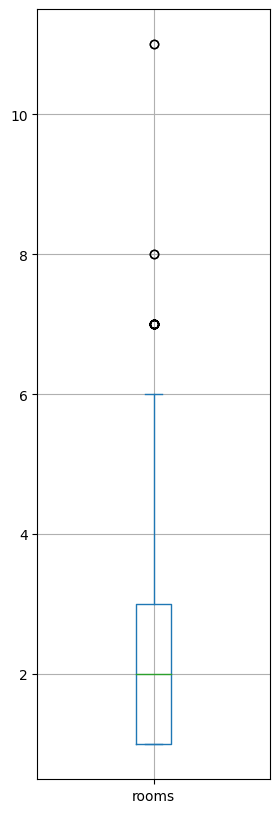

In [76]:
print(data.rooms.describe())
data.rooms.plot(kind = 'box', figsize = (3, 10), grid = True)
plt.show()

<div class="alert alert-info"> 
C комнатами вроде все хорошо, хотя больше 6 можно и удалить, чтобы сильно не выбивались.
</div>

count    22790.000000
mean         2.039008
std          0.943959
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: rooms, dtype: float64


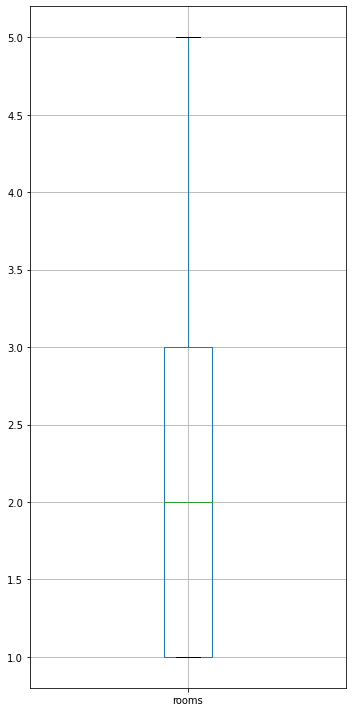

In [ ]:
data = data.query('rooms < 6')
print(data.rooms.describe())
data.rooms.plot(kind = 'box', figsize = (5, 10), grid = True)
plt.tight_layout()
plt.show()

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все супер!👍:</b> Хорошо)

### Посчитайте и добавьте в таблицу новые столбцы

- цена одного квадратного метра;
- день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
- месяц публикации объявления;
- год публикации объявления;
- тип этажа квартиры (значения — «‎первый», «последний», «другой»);
- расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).

In [ ]:
# расчет цены квадратного метра
data['price_of_metr'] = round(data['last_price']/data['total_area'],2)
data.sample(5)

,total_images,last_price,living_area,total_area,kitchen_area,floor,first_day_exposition,rooms,ceiling_height,floors_total,is_apartment,studio,open_plan,balcony,locality_type,locality_name,locality_full_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_of_metr
8863,6,2980000,18.1,31.3,9.04,1,2016-06-28,1,2.65,5,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,27594.0,8302.0,0,3000.0,0,3000.0,57,95207.67
19333,7,6000000,54.8,70.0,8.40,3,2019-04-03,3,2.65,5,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,30118.0,8965.0,2,384.0,0,3000.0,0,85714.29
10341,6,6200000,31.0,53.0,10.00,1,2017-08-08,2,3.10,5,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,22961.0,2256.0,1,159.0,3,55.0,158,116981.13
841,15,6195000,34.0,56.0,8.30,10,2015-04-19,2,2.65,14,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,41424.0,10304.0,1,288.0,0,3000.0,919,110625.00
13642,12,6300000,33.0,53.0,7.70,3,2017-07-29,2,3.40,4,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,21368.0,2017.0,2,412.0,1,371.0,104,118867.92


In [ ]:
# Добавление столбцов с днем недели, месяцем и годом публикации объявления
data['day_of_week'] = data['first_day_exposition'].dt.day_name()
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year
data.sample(5)

,total_images,last_price,living_area,total_area,kitchen_area,floor,first_day_exposition,rooms,ceiling_height,floors_total,is_apartment,studio,open_plan,balcony,locality_type,locality_name,locality_full_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_of_metr,day_of_week,month,year
6982,10,4000000,30.0,45.0,7.2,4,2016-02-11,2,2.65,5,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,46224.0,14877.0,1,492.0,0,3000.0,140,88888.89,Thursday,2,2016
1406,9,4900000,35.0,69.0,17.0,6,2017-05-30,2,3.20,8,False,False,False,2,поселок,Бугры,поселок Бугры,100000.0,0.0,0,3000.0,0,3000.0,59,71014.49,Tuesday,5,2017
2974,13,3200000,29.2,46.3,7.0,2,2018-03-31,2,2.50,3,False,False,False,1,,Зеленогорск,Зеленогорск,81355.0,62454.0,0,3000.0,0,3000.0,205,69114.47,Saturday,3,2018
21744,0,4550000,14.0,31.4,10.0,17,2018-10-29,1,2.50,19,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,32781.0,8684.0,0,3000.0,0,3000.0,35,144904.46,Monday,10,2018
15885,9,3350000,17.2,31.0,6.0,4,2016-07-06,1,2.60,7,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,42049.0,14554.0,1,608.0,0,3000.0,509,108064.52,Wednesday,7,2016


In [ ]:
# Категоризирую этажи
data['type_of_floor'] = data.apply(lambda x: type_of_floor(x.floor, x.floors_total), axis = 1)
data.head()

,total_images,last_price,living_area,total_area,kitchen_area,floor,first_day_exposition,rooms,ceiling_height,floors_total,is_apartment,studio,open_plan,balcony,locality_type,locality_name,locality_full_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_of_metr,day_of_week,month,year,type_of_floor
0,20,13000000,51.0,108.0,25.0,8,2019-03-07,3,2.70,16,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,0,120370.37,Thursday,3,2019,другой
1,7,3350000,18.6,40.4,11.0,1,2018-12-04,1,2.65,11,False,False,False,2,поселок,Шушары,поселок Шушары,12817.0,18603.0,0,3000.0,0,3000.0,81,82920.79,Tuesday,12,2018,первый
2,10,5196000,34.3,56.0,8.3,4,2015-08-20,2,2.65,5,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558,92785.71,Thursday,8,2015,другой
3,0,64900000,45.0,159.0,9.5,9,2015-07-24,3,2.65,14,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424,408176.10,Friday,7,2015,другой
4,2,10000000,32.0,100.0,41.0,13,2018-06-19,2,3.03,14,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121,100000.00,Tuesday,6,2018,другой


In [ ]:
# Добавляю столбец с расстоянием до центра в километрах
data['cityCenters_nearest_KM'] = data['cityCenters_nearest']/1000
data['cityCenters_nearest_KM'] = data['cityCenters_nearest_KM'].astype(int)
data.sample(10)

,total_images,last_price,living_area,total_area,kitchen_area,floor,first_day_exposition,rooms,ceiling_height,floors_total,is_apartment,studio,open_plan,balcony,locality_type,locality_name,locality_full_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_of_metr,day_of_week,month,year,type_of_floor,cityCenters_nearest_KM
6025,7,2650000,34.20,47.30,5.00,5,2017-12-01,3,2.50,5,False,False,False,1,,Тосно,Тосно,100000.0,0.0,0,3000.0,0,3000.0,0,56025.37,Friday,12,2017,последний,0
15171,15,25000000,42.00,107.00,36.00,3,2019-02-22,2,2.65,12,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,25799.0,4593.0,0,3000.0,2,840.0,0,233644.86,Friday,2,2019,другой,4
8287,17,5240000,42.91,63.19,6.83,5,2017-09-16,3,2.57,9,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,17399.0,15786.0,1,587.0,0,3000.0,373,82924.51,Saturday,9,2017,другой,15
11456,10,4500000,38.60,63.00,9.90,3,2017-08-16,2,2.70,5,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,20388.0,19391.0,1,187.0,0,3000.0,71,71428.57,Wednesday,8,2017,другой,19
16283,20,3600000,41.30,60.30,7.80,2,2018-02-13,2,2.65,3,False,False,False,0,городской поселок,Виллози,городской поселок Виллози,100000.0,0.0,0,3000.0,0,3000.0,126,59701.49,Tuesday,2,2018,другой,0
9993,2,10500000,34.00,70.50,12.60,21,2019-02-25,2,3.00,23,False,False,False,2,,Санкт-Петербург,Санкт-Петербург,18695.0,16268.0,1,51.0,1,344.0,21,148936.17,Monday,2,2019,другой,16
2104,11,3150000,18.40,32.00,5.20,3,2018-02-25,1,2.65,5,False,False,False,0,,Пушкин,Пушкин,14600.0,26754.0,0,3000.0,0,3000.0,127,98437.50,Sunday,2,2018,другой,26
17247,12,8750000,56.00,100.40,9.00,12,2017-09-23,4,2.50,18,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,14241.0,14793.0,1,1148.0,2,688.0,275,87151.39,Saturday,9,2017,другой,14
22776,18,9000000,40.00,67.80,12.00,12,2018-10-05,2,2.80,16,False,False,False,0,,Санкт-Петербург,Санкт-Петербург,34234.0,11703.0,0,3000.0,0,3000.0,12,132743.36,Friday,10,2018,другой,11
16352,17,3800000,17.60,38.00,10.60,3,2016-05-17,1,2.65,23,False,False,False,1,,Санкт-Петербург,Санкт-Петербург,43254.0,12012.0,0,3000.0,0,3000.0,263,100000.00,Tuesday,5,2016,другой,12


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все супер!👍:</b> Столбцы добавлены верно!

### Проведите исследовательский анализ данных

#### Изучите следующие параметры объектов:
- общая площадь;
- жилая площадь;
- площадь кухни;
- цена объекта;
- количество комнат;
- высота потолков;
- этаж квартиры;
- тип этажа квартиры («первый», «последний», «другой»);
- общее количество этажей в доме;
- расстояние до центра города в метрах;
- расстояние до ближайшего аэропорта;
- расстояние до ближайшего парка;
- день и месяц публикации объявления.

    Постройте отдельные гистограммы для каждого из этих параметров. Опишите все ваши наблюдения по параметрам в ячейке с типом markdown.

In [ ]:
data.columns

Index(['total_images', 'last_price', 'living_area', 'total_area',
       'kitchen_area', 'floor', 'first_day_exposition', 'rooms',
       'ceiling_height', 'floors_total', 'is_apartment', 'studio', 'open_plan',
       'balcony', 'locality_type', 'locality_name', 'locality_full_name',
       'airports_nearest', 'cityCenters_nearest', 'parks_around3000',
       'parks_nearest', 'ponds_around3000', 'ponds_nearest', 'days_exposition',
       'price_of_metr', 'day_of_week', 'month', 'year', 'type_of_floor',
       'cityCenters_nearest_KM'],
      dtype='object')

In [ ]:
data.select_dtypes(['float', 'int']).columns

Index(['total_images', 'last_price', 'living_area', 'total_area',
       'kitchen_area', 'floor', 'rooms', 'ceiling_height', 'floors_total',
       'balcony', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'price_of_metr', 'month', 'year',
       'cityCenters_nearest_KM'],
      dtype='object')

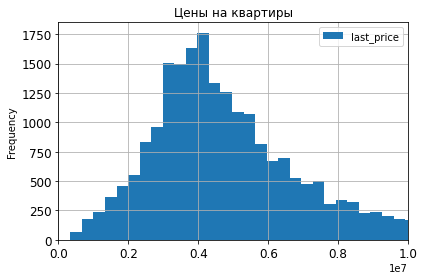

count    2.279000e+04
mean     6.024644e+06
std      6.179851e+06
min      1.219000e+04
25%      3.450000e+06
50%      4.650000e+06
75%      6.700000e+06
max      3.300000e+08
Name: last_price, dtype: float64

In [ ]:
# Анализ характеристики "Цена продажи"
data.plot(
    y = 'last_price', 
    kind = 'hist', 
    bins = 1000, 
    grid = True, 
    title = "Цены на квартиры",
    fontsize = 12,
    xlim = (0,1e7),
)
plt.tight_layout()
plt.show()
data.last_price.describe()

<div class="alert alert-info">
<b>Вывод по графику:</b> <i>больше всего квартир продается примерно за 4 000 000 руб. Форма распределения близка к нормальному.</i>
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v2 <a class="tocSkip"> </h2>

<b>Все супер!👍:</b> Хорошо, верно)
    

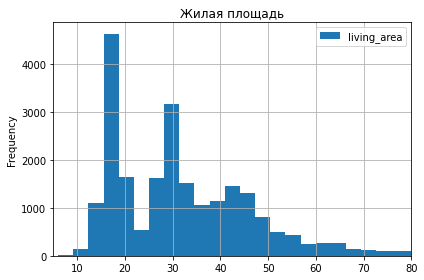

count    22790.000000
mean        33.004041
std         16.534064
min          6.000000
25%         18.500000
50%         30.295000
75%         42.000000
max        164.700000
Name: living_area, dtype: float64

In [ ]:
# Анализ 'living_area'
data.plot(
    y = 'living_area', 
    kind = 'hist', 
    bins = 50,
    grid = True, 
    title = "Жилая площадь",
    xlim = (5,80),
)
plt.tight_layout()
plt.show()
data.living_area.describe()

***Вывод по графику:*** *распределение имеет две ярко выраженные моды, это квартиры с **жилой** площадью около 16 кв.м. и 30 кв.м.. Скорее всего это однокомнатные и двухкомнатные. Третья мода менее всего выражена, квартиры с **жилой** площадью 43-44 кв.м.*

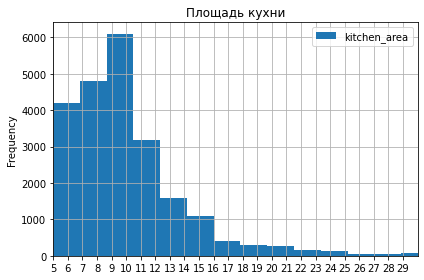

count    22790.000000
mean        10.255491
std          5.127079
min          1.300000
25%          7.200000
50%          9.040000
75%         11.397500
max         93.200000
Name: kitchen_area, dtype: float64

In [ ]:
# Анализ 'kitchen_area'
data.plot(
    y = 'kitchen_area', 
    kind = 'hist', 
    bins = 50,
    grid = True, 
    title = "Площадь кухни",
    xlim = (5,30),
    xticks = range(1,30),
)
plt.tight_layout()
plt.show()
data.kitchen_area.describe()

<div class="alert alert-info">
<b>Вывод по графику:</b> <i>наиболее распространены квартиры с площадью кухни в районе 9-10 кв.м. Форма распределения - Пуассона.</i>
</div>    

<div class="alert alert-success">
<h2> Комментарий ревьюера v2 <a class="tocSkip"> </h2>

<b>Все супер!👍:</b> В точку!

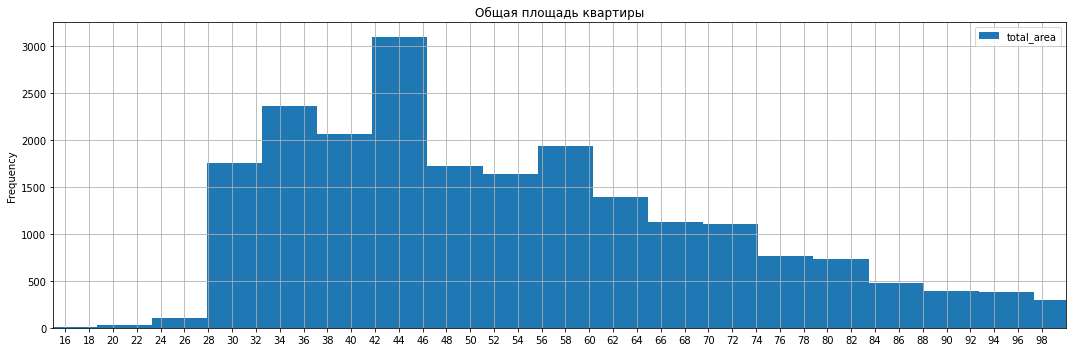

count    22790.000000
mean        58.246202
std         25.689468
min         14.000000
25%         40.200000
50%         52.000000
75%         69.000000
max        199.200000
Name: total_area, dtype: float64

In [ ]:
# Анализ 'total_area'
import numpy as np
data.plot(
    y = 'total_area', 
    kind = 'hist', 
    bins = 40,
    grid = True, 
    title = "Общая площадь квартиры",
    xlim = (15,100),
    figsize = (15,5),
    rot = 0,
    xticks = np.arange(14,100,2),
)
plt.tight_layout()
plt.show()
data.total_area.describe()

***Вывод по графику:*** *больше всего квартир **общей** площадью от 42 до 46 кв.м., на втором месте квартиры площадью от 33 до 37 кв.м., на третьем - от 56 до 60 кв.м.*

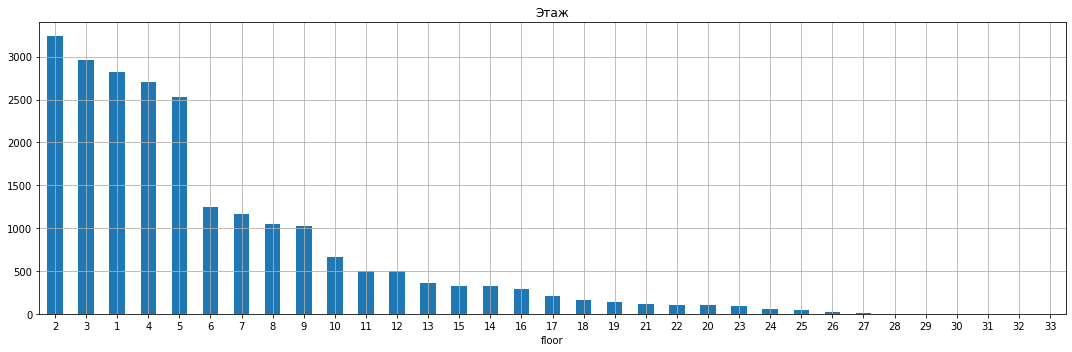

count    22790.000000
mean         5.864239
std          4.852016
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

In [ ]:
# Анализ 'floor'
data.groupby('floor')['floor'].count().sort_values(ascending = False).plot(
    x = data.groupby('floor')['floor'].count().index,
    y = data.groupby('floor')['floor'].count(), 
    kind = 'bar', 
    grid = True, 
    title = "Этаж",
    figsize = (15,5),
    rot = 0,
)
plt.tight_layout()
plt.show()
data.floor.describe()

***Вывод по графику:*** *больше всего квартир продают на 2 этаже, на втором месте - 3 этаж, на третьем и четвертом - 1 и 4 этажи.*

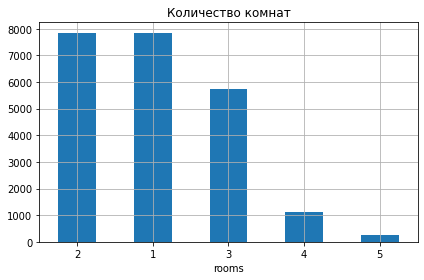

count    22790.000000
mean         2.039008
std          0.943959
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: rooms, dtype: float64

In [ ]:
# Анализ 'rooms'
data.groupby('rooms')['rooms'].count().sort_values(ascending = False).plot(
    x = data.groupby('rooms')['rooms'].count().index,
    y = data.groupby('rooms')['rooms'].count(), 
    kind = 'bar', 
    grid = True, 
    title = "Количество комнат",
    rot = 0,
)
plt.tight_layout()
plt.show()
data.rooms.describe()

***Вывод по графику:*** *на рынке недвижимости очень много однушек и двушек (практически одинаковое количество), при этом предложений с трехкомнатными квартирами меньше почти на 1000.*

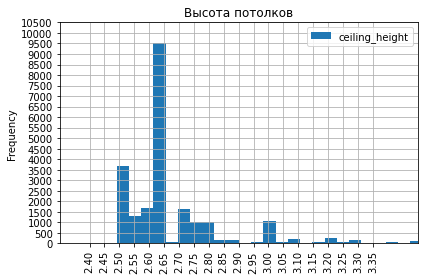

count    22790.000000
mean         2.691146
std          0.203378
min          2.450000
25%          2.600000
50%          2.650000
75%          2.700000
max          4.500000
Name: ceiling_height, dtype: float64

In [ ]:
# Анализ 'ceiling_height'
data.plot(
    y = 'ceiling_height', 
    kind = 'hist', 
    bins = 50,
    grid = True, 
    title = "Высота потолков",
    xlim = (2.3,3.5),
    rot = 90,
    xticks = np.arange(2.4,3.4,0.05),
    yticks = range(0,11000,500),
)
plt.tight_layout()
plt.show()

data.ceiling_height.describe()

***Вывод по графику:*** *самое большое количество квартир с высотой потолков в районе 2,6 м, на втором месте, с отставанием в 6 тысяч предложений, с высотой 2,5 м.*

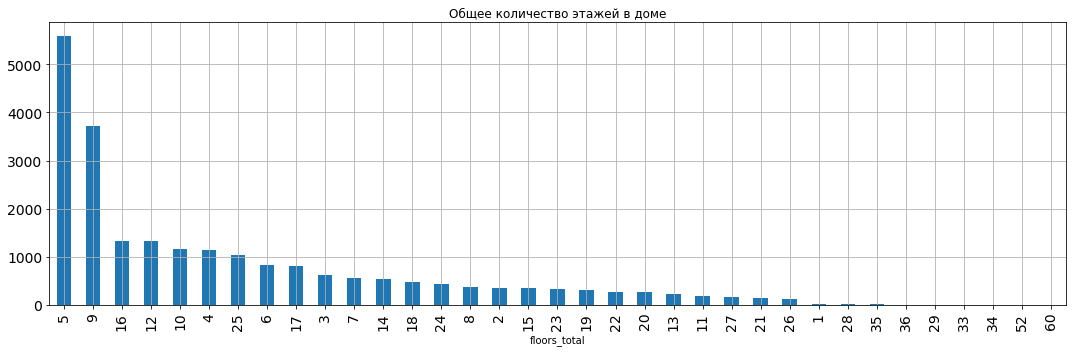

count    22790.000000
mean        10.668100
std          6.560879
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

In [ ]:
# Анализ 'floors_total'
data.groupby('floors_total')['floors_total'].count().sort_values(ascending = False).plot(
    x = data.groupby('floors_total')['floors_total'].count().index,
    y = data.groupby('floors_total')['floors_total'].count(), 
    kind = 'bar', 
    grid = True, 
    title = "Общее количество этажей в доме",
    figsize = (15,5),
    fontsize = 14,
)
plt.tight_layout()
plt.show()
data.floors_total.describe()

***Вывод по графику:*** *больше всего квартир находятся в пятиэтажках, на втором месте - девятиэтажки, на третьем 12-ти и 16-ти этажные дома.*

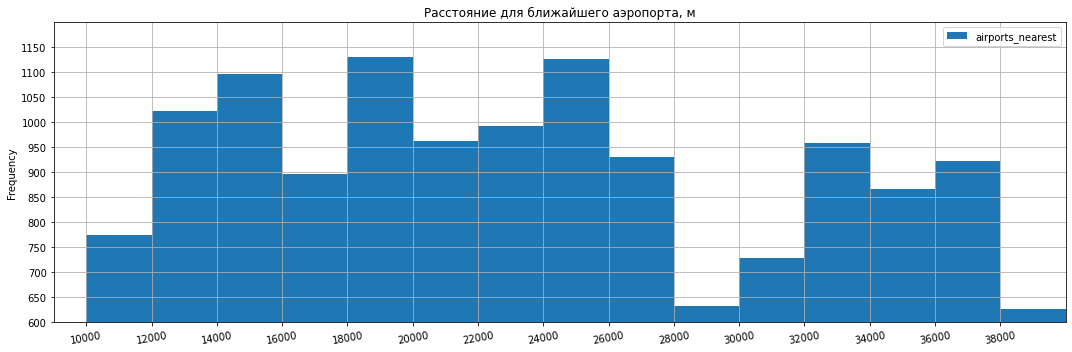

count     22790.000000
mean      45515.504081
std       32069.004412
min           0.000000
25%       21103.000000
50%       33673.000000
75%       54253.500000
max      100000.000000
Name: airports_nearest, dtype: float64

In [ ]:
# Анализ 'airports_nearest'
data.plot(
    y = 'airports_nearest', 
    kind = 'hist', 
    bins = 50,
    grid = True, 
    title = "Расстояние для ближайшего аэропорта, м",
    xlim = (9000,40000),
    ylim = (600,1200),
    figsize = (15,5),
    rot = 10,
    xticks = range(10000,40000,2000),
    yticks = range(0,1200,50),
)
plt.tight_layout()
plt.show()
data.airports_nearest.describe()

***Вывод по графику:*** *основная масса квартир находится на расстоянии 12 - 28 км от аэропорта.*

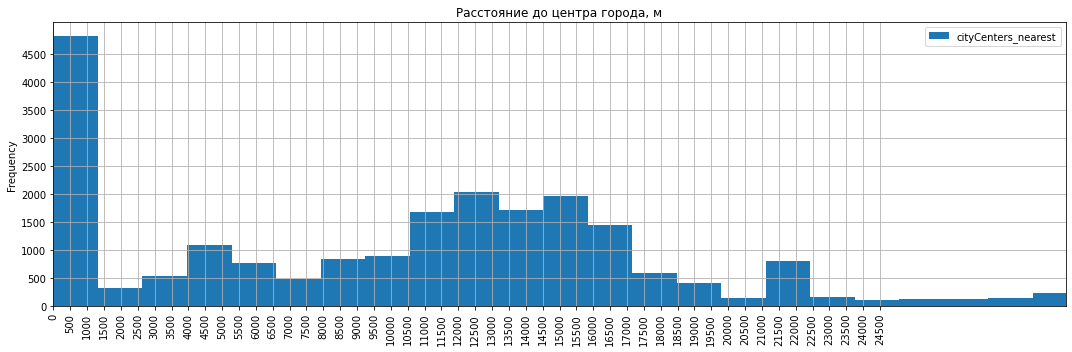

count    22790.000000
mean     11590.581330
std       9674.447135
min          0.000000
25%       3953.000000
50%      11831.000000
75%      15753.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

In [ ]:
# Анализ 'cityCenters_nearest'
data.plot(
    y = 'cityCenters_nearest', 
    kind = 'hist', 
    bins = 50,
    grid = True, 
    title = "Расстояние до центра города, м",
    xlim = (0,30000),
    figsize = (15,5),
    rot = 90,
    xticks = range(0,25000,500),
    yticks = range(0,5000,500),
)
plt.tight_layout()
plt.show()
data.cityCenters_nearest.describe()

***Вывод по графику:*** *Больше всего квартир находятся в центре населенного пункта. но и не мало квартир на расстоянии от 10 до 17 км. от центра.*

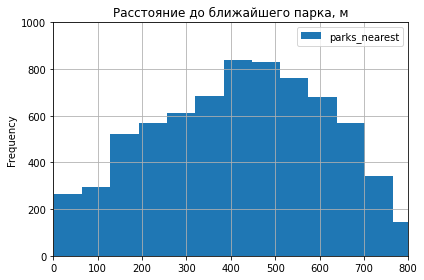

count    22790.000000
mean      2149.206626
std       1204.194580
min          1.000000
25%        604.000000
50%       3000.000000
75%       3000.000000
max       3190.000000
Name: parks_nearest, dtype: float64

In [ ]:
# Анализ 'parks_nearest'
data.plot(
    y = 'parks_nearest', 
    kind = 'hist', 
    bins = 50,
    grid = True, 
    title = "Расстояние до ближайшего парка, м",
    xlim = (0,800),
    ylim = (0,1000),
)
plt.tight_layout()
plt.show()
data.parks_nearest.describe()

***Вывод по графику:*** *В основном квартиры находятся на расстоянии 450 м. от ближайшего парка.*

In [ ]:
data.groupby('day_of_week')['day_of_week'].count()

day_of_week
Friday       3846
Monday       3494
Saturday     1872
Sunday       1625
Thursday     4112
Tuesday      4029
Wednesday    3812
Name: day_of_week, dtype: int64

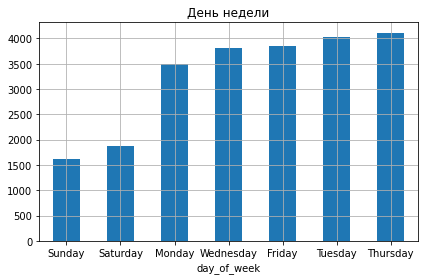

count        22790
unique           7
top       Thursday
freq          4112
Name: day_of_week, dtype: object

In [ ]:
# Анализ 'day_of_week'
data.groupby('day_of_week')['day_of_week'].count().sort_values().plot(
    x = data.groupby('day_of_week')['day_of_week'].count().index,
    y = data.groupby('day_of_week')['day_of_week'].count(),
    kind = 'bar', 
    #bins = 100,
    grid = True, 
    title = "День недели",
    rot = 0,
)
plt.tight_layout()
plt.show()
data.day_of_week.describe()

***Вывод по графику:*** *Чаще всего объявления размещают на буднях, особенно в четверг. Наиболее редко - на выходных, особенно в воскресенье.*

In [ ]:
['last_price', 'living_area', 'total_area','kitchen_area', 'floor', 'rooms', 'ceiling_height','floors_total','airports_nearest', 'cityCenters_nearest', 'parks_nearest','day_of_week', 'month']


['last_price',
 'living_area',
 'total_area',
 'kitchen_area',
 'floor',
 'rooms',
 'ceiling_height',
 'floors_total',
 'airports_nearest',
 'cityCenters_nearest',
 'parks_nearest',
 'day_of_week',
 'month']

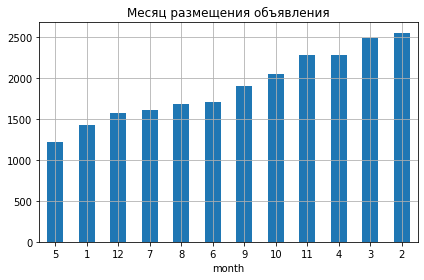

In [ ]:
# Анализ 'month'
data.groupby('month')['month'].count().sort_values().plot(
    x = data.groupby('month')['month'].count().index,
    y = data.groupby('month')['month'].count(),
    kind = 'bar', 
    grid = True, 
    title = "Месяц размещения объявления",
    rot = 0,
)
plt.tight_layout()
plt.show()

***Вывод по графику:*** *Чаще всего объявления размещают в феврале и марте, а реже всего в мае.*

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Небольшие замечания и рекомендации💡:</b> По описанию парамтеров все окей, но мне не хватило определенного типа распределения у каждого графика

---
#### Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней было размещено каждое объявление.
- Постройте гистограмму.
- Посчитайте среднее и медиану.
- В ячейке типа markdown опишите, сколько времени обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?

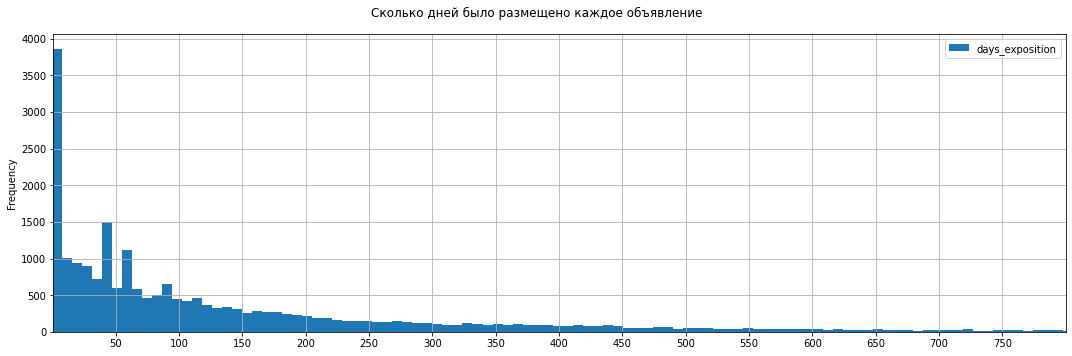

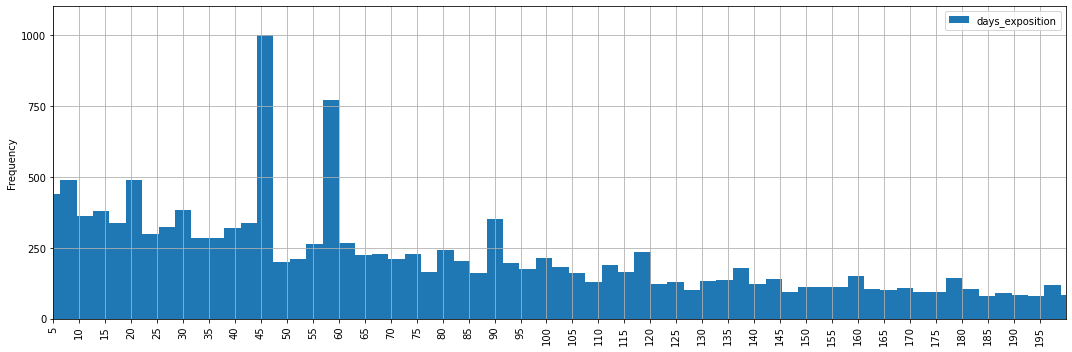

count    19741.000000
mean       180.584165
std        218.945330
min          1.000000
25%         45.000000
50%         96.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [ ]:
# Анализ 'days_exposition'
data.plot(
    y = 'days_exposition', 
    kind = 'hist', 
    bins = 200,
    grid = True, 
    title = "Cколько дней было размещено каждое объявление",
    xlim = (1,800),
    figsize = (15,5),
    subplots = True,
    xticks = range(0,800,50),
)
plt.tight_layout()
plt.show()
data.plot(
    y = 'days_exposition', 
    kind = 'hist', 
    bins = 500,
    grid = True, 
    xlim = (5,200),
    ylim = (0,1100),
    figsize = (15,5),
    rot = 90,
    subplots = True,
    xticks = range(0,200,5),
    yticks = range(0,1100,250),
)
plt.tight_layout()
plt.show()
data.query('days_exposition > 0').days_exposition.describe()

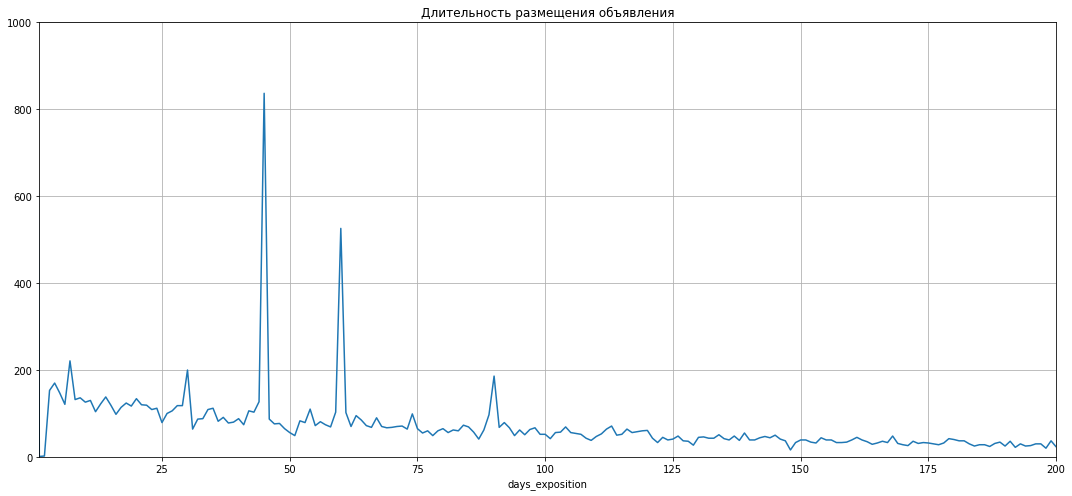

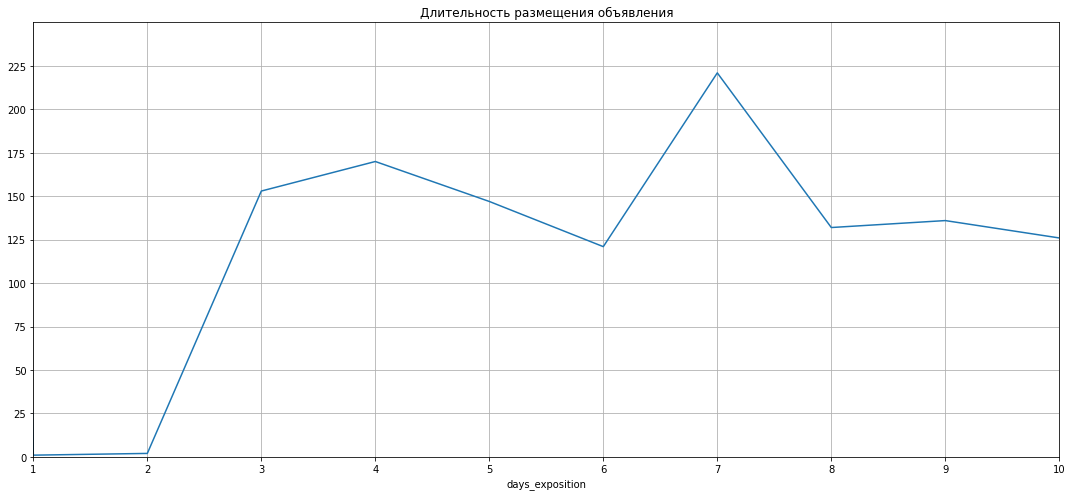

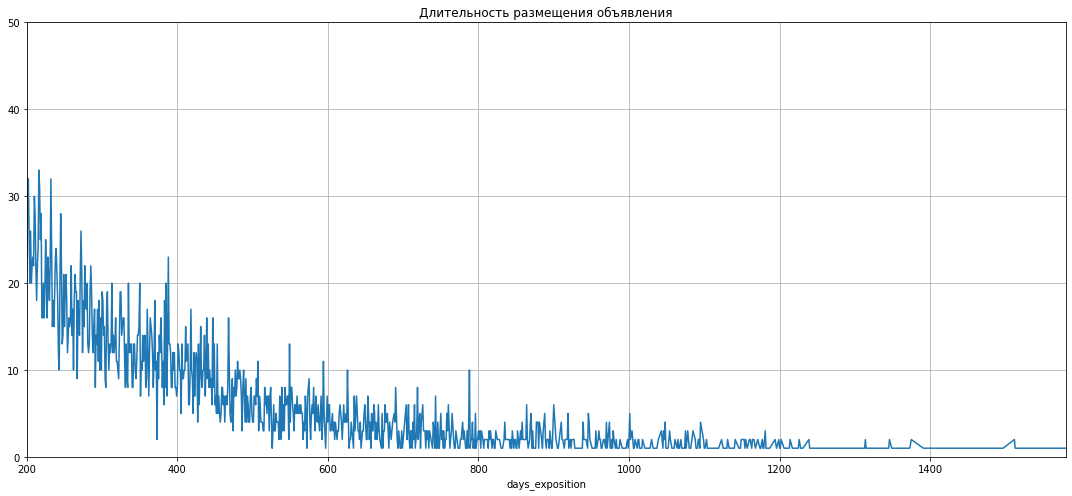

In [ ]:
# Анализ 'days_exposition' ДОРАБОТКА!
data.groupby('days_exposition')['days_exposition'].count().plot(
    x = data.groupby('days_exposition')['days_exposition'].count().index,
    y = data.groupby('days_exposition')['days_exposition'].count(),
    kind = 'line', 
    grid = True, 
    title = "Длительность размещения объявления",
    rot = 0,
    figsize = (15, 7), 
    xlim = (1,200),
    ylim = (0,1000),
    #xticks = range(0,200,5),
)
plt.tight_layout()
plt.show()
# Изучение быстрых продаж
data.groupby('days_exposition')['days_exposition'].count().plot(
    x = data.groupby('days_exposition')['days_exposition'].count().index,
    y = data.groupby('days_exposition')['days_exposition'].count(),
    kind = 'line', 
    grid = True, 
    title = "Длительность размещения объявления",
    rot = 0,
    figsize = (15, 7), 
    xlim = (1,10),
    ylim = (0,250),
    xticks = range(0,200,1),
    yticks = range(0,250,25),
)
plt.tight_layout()
plt.show()
# Изучение медленных продаж
data.groupby('days_exposition')['days_exposition'].count().plot(
    x = data.groupby('days_exposition')['days_exposition'].count().index,
    y = data.groupby('days_exposition')['days_exposition'].count(),
    kind = 'line', 
    grid = True, 
    title = "Длительность размещения объявления",
    rot = 0,
    figsize = (15, 7), 
    xlim = (200,1580),
    ylim = (0,50),
    #xticks = range(0,200,1),
    #yticks = range(0,250,25),
)
plt.tight_layout()
plt.show()

In [ ]:
# Подсчет количества объявлений, срок размещения которых менее 10 дней
data.query('days_exposition < 10').days_exposition.count()

4132

In [ ]:
# Подсчет количества объявлений, срок размещения которых более 200 дней
data.query('days_exposition > 200').days_exposition.count()

5639

***Вывод по графику:*** *В подавляющем числе случаев квартиры продаются менее чем за 10 дней (что странно, но так гласит верхний график), но далее есть пик - 45 дней. Возможно, это максимальный срок размещения объявления. Следующий пик в районе 57 дней. В общем и целом квартиры продаются довольно быстро, но есть и такие, срок продажи которых достигает нескольких лет.*

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

<b>На доработку 🤔:</b>  Как-то неявно мы ответили на поставленные впоросы. Какие продажи будем считать быстрыми? Какие необычно долгими?  А что за подавляющее большинстов в пределах 10 дней? Это из-за выброса на 0 дней, но ведь мы там вводили заглушку. По поводу пиков на 45, 60 и других днях - причина здесь в том, что платформа в эти дни сама снимает объявления.

<div class="alert alert-info">
<i>Сейчас заметил, что есть пик на 7 днях, т.е. такие продажи буду считать аномально быстрыми, а объявления, размещенные более 200 дней - медленными. При этом и медленных, и быстрых продаж примерно по 25 % от общего числа объявлений.</i>
</div>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера v2 <a class="tocSkip"> </h2>
    
<b>Небольшие замечания и рекомендации💡:</b> Ага, хорошо. Раз до 7 дней аномально быстыре, предполагаю, что быстрыми ты будешь считать от 7 дней до 30, скажем, что верно, ведь нас интересуют именно быстрые. А вот необычно долгие как раз медленные) Здесь я бы говорил о 300-400 днях

#### Какие факторы больше всего влияют на общую (полную) стоимость объекта?
    Изучите, зависит ли цена от:
- общей площади;
- жилой площади;
- площади кухни;
- количества комнат;
- этажа, на котором расположена квартира (первый, последний, другой);
- даты размещения (день недели, месяц, год).

    Постройте графики, которые покажут зависимость цены от указанных выше параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы.

In [ ]:
data_spb.columns
#['last_price','living_area', 'total_area','kitchen_area','rooms','type_of_floor','day_of_week', 'month', 'year']

NameError: name 'data_spb' is not defined

In [ ]:
# Анализ зависимости цены квартиры от жилой площади
data.plot(
    x = 'total_area',
    xlabel = 'Общая площадь, м.кв.',
    y = 'last_price',
    ylabel = 'Цена за квартиру, руб.',
    kind = 'scatter', 
    grid = True, 
    figsize = (9,9),
    title = "Зависимость цены от общей площади квартиры",
    ylim = (0,15e7),
)
plt.tight_layout()
plt.show()

***Вывод по графику:*** *из графика видна неярко выраженная прямая зависимость цены от общей площади квартиры.*

In [ ]:
# Анализ зависимости цены квартиры от жилой площади
data.plot(
    x = 'living_area',
    xlabel = 'Жилая площадь, м.кв.',
    y = 'last_price',
    ylabel = 'Цена за квартиру, руб.',
    kind = 'scatter', 
    grid = True, 
    figsize = (9,9),
    title = "Зависимость цены от размера жилой площади",
    ylim = (0,1e8),
)
plt.tight_layout()
plt.show()

***Вывод по графику:*** *из графика видна неярко выраженная прямая зависимость цены от жилой площади квартиры.*

In [ ]:
# Анализ зависимости цены квартиры от площади кухни
data.plot(
    x = 'kitchen_area',
    xlabel = 'Площадь кухни, м.кв.',
    y = 'last_price',
    ylabel = 'Цена за квартиру, руб.',
    kind = 'scatter', 
    grid = True, 
    figsize = (9,9),
    title = "Зависимость цены от размера площади кухни",
    xlim = (0,40),
    ylim = (0,1e8),
)
plt.tight_layout()
plt.show()

***Вывод по графику:*** *видна слабая зависимость цены квартиры от площади кухни.*

In [ ]:
# Анализ зависимости цены квартиры от количества комнат
data.plot(
    x = 'rooms',
    xlabel = 'Количество комнат, м.кв.',
    y = 'last_price',
    ylabel = 'Цена за квартиру, руб.',
    kind = 'scatter', 
    grid = True, 
    title = "Зависимость цены от количества комнат в квартире",
)
plt.tight_layout()
plt.show()

***Вывод по графику:*** *самая высокая цена на трех- и четырехкомнатные квартиры, а самая низкая - на однокомнатные.*

In [ ]:
# Анализ зависимости цены квартиры от количества комнат
data.plot(
    x = 'type_of_floor',
    xlabel = 'Этаж, м.кв.',
    y = 'last_price',
    ylabel = 'Цена за квартиру, руб.',
    ylim = (0, 1e8),
    kind = 'scatter', 
    grid = True, 
    title = "Зависимость цены от этажа",
)
plt.tight_layout()
plt.show()

***Вывод по графику:*** *Самые дешевые квартиры расположены на 1 этаже, немного дороже - на последнем, а самые дорогие на остальных этажах.*

In [ ]:
# Анализ зависимости цены квартиры от дня размещения объявления
data.plot(
    x = 'day_of_week',
    xlabel = 'День недели',
    y = 'last_price',
    ylabel = 'Цена за квартиру, руб.',
    ylim = (0,1e8),
    kind = 'scatter', 
    grid = True, 
    title = "Зависимость цены от \nдня размещения объявления",
)
plt.tight_layout()
plt.show()

In [ ]:
data.groupby(['day_of_week'])['last_price'].sum().sort_values(ascending = False).plot(kind='bar', sort_columns = True)
plt.title('Зависимость цены от \nдня размещения объявления')
plt.tight_layout()

***Вывод по графику:*** *самые дешевые квартиры в объявлениях, размещенных по воскресеньям, а самые дорогие - по четвергам.*

In [ ]:
# Анализ зависимости цены квартиры от месяца размещения объявления
data.groupby(['month'])['last_price'].sum().sort_values(ascending = False).plot(kind='bar', sort_columns = True)
plt.title('Зависимость цены от месяца\n размещения объявления')
plt.tight_layout()

***Вывод по графику:*** *cамые дорогие квартиры продают в феврале, а самые дешевые - в мае.*

In [ ]:
# Анализ зависимости цены квартиры от года размещения объявления
data.groupby(['year'])['last_price'].sum().sort_values(ascending = False).plot(kind='bar', sort_columns = True)
plt.title('Зависимость цены от года\n размещения объявления')
plt.tight_layout()
data[['year','last_price']].corr()

***Вывод по графику:*** *квартиры дорожали до 2018 года, но в 2019 почему-то подешевели. Возможно потому, что выборка имеет не все данные о квартирах в 2019 года.*

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

<b>На доработку🤔:</b>  А корреляции будем считать?)

In [ ]:
data_spb[['last_price','living_area', 'total_area','kitchen_area','rooms','type_of_floor','day_of_week', 'month', 'year']].corr()[['last_price']].sort_values(by = 'last_price', ascending = False)

<div class="alert alert-info">
<i>
    Наибольшая зависимость, как я заметил ранее, между ценой квартиры и общей площадью - 0.66, наименьшая корреляция между ценой и месяцем размещения объявления.
</i>
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v2 <a class="tocSkip"> </h2>

<b>Все супер!👍:</b> Ага, отлично, молодец)

---
#### Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце locality_name.

In [ ]:
cities = list(data['locality_name'].value_counts().head(10).index) #Список населенных пунктов с максимальным числом объявлений
data.query('locality_name.isin(@cities)').groupby('locality_name')['price_of_metr'].agg(['min', 'mean', 'max', 'median']).sort_values(by = 'mean', ascending = False)

***Вывод:*** *самая высокая средняя цена квадратного метра в Санкт-Петербурге - 113 355 руб., самая низкая - в Выборге - 57 972 руб.*

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все супер!👍:</b> Верно!

---
#### Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города.

In [ ]:
data_spb = data.query('locality_name == "Санкт-Петербург"')
data_spb.groupby('cityCenters_nearest_KM')['last_price'].mean().plot(
    kind = 'line',
    figsize = (15,5),
    grid = True,
    title = 'Зависимость цены квадратного метра от расстояния до центра Санкт-Петербурга'
)
plt.show()

***Вывод:*** *чем дальше от центра, тем дешевее квадратный метр.*

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Небольшие замечания и рекомендации💡:</b> А как можно объяснить появление пиков на графике?
        

<div class="alert alert-info">
<i>
    <b>По поводу пиков.</b> Я считаю, что они обусловлены не только расстоянием до центра, но и определенным районом. Я из СПб, и знаю, что есть районы города, где цены на кв.м. гораздо выше, чем в центральном. Например, район Крестовского острова или Васильевский остров (как раз примерно семи километрах от центра) или Курортный район, питерская "рублевка", (более 25 км от центра) как и Петергоф. Однако, чем объяснить пик в 20 км... Может быть это квартиры в новостройках, опоясывающих Спб.
</i>
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v2 <a class="tocSkip"> </h2>

<b>Все супер!👍:</b> А, супер) Расставил все на свои места. Молодец!

### Общий вывод

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод

***Общий вывод:***

*Больше всего на цену квартиры влияет расположение квартиры (город и расстояние до центра) и площадь, т.е. чем крупнее город, ближе к центру и больше площадь, тем дороже квартиры.*

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

<b>На доработку🤔:</b>  Исправим ошибки и вернемся к итоговому выводу

<div class="alert alert-info">
<i>
    <b>Общий вывод - доработка:</b> 
    Я еще более убедился в том, что цена на квартиру более всего зависит от площади, однако расстояние от центра не всегда является решающим. Есть определенные районы, находящиеся в отдалении, где цены выше. 
    
    P.S.: Сейчас мысль возникла. Помимо расстояния от центра в Питере еще важно, насколько обхекты удалены от метро, хотя таких данных у нас, к сожалению, нет.
</i>
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v2 <a class="tocSkip"> </h2>

<b>Все супер!👍:</b> Кстати говоря, было бы здорово, если бы у нас были данные по удаленности от метро. Жаль, тчо их нет

<div style="border:solid Chocolate 2px; padding: 40px">
    
**Общий вывод по проекту ревьювера**:
 Андрей, спасибо за  проект! Ты приложил много усилий, чтобы довести его до конца, проделана огромная работа, и это видно невооруженным глазом, ты большой молодец!
    
**Отмечу положительные моменты**:
    
    1. Все разложено по полочкам, всегда понятен ход твоих мыслей, приятно смотреть
    
    2. Отличные визуализации
    
    2. На разных шагах проекта ты предлагала очень интересные решения и методы для их реализации. Хорошая работа!
    
    
**На что стоит обратить внимание**:
    
    1. Не полный вывод по первому разделу

    2. Неявно ответили на вопрос о быстрых и необычно медленных продажах

    3. Для зависимостей разных параметров от цены не посчитаны корреляции
    
    
**Удачи и жду твой проект на повторное ревью!**

<div style="border:solid Chocolate 2px; padding: 40px">
    
**Общий вывод по проекту ревьювера v2**:
 Андрей, ошибки исправлены, проект принят, поздравляю тебя! Успешной учебы и еще увидимся в Практикуме!